# Using NLP for sentiment analysis
See https://huggingface.co/blog/sentiment-analysis-python.
<br> Also, see https://ieeexplore.ieee.org/document/8848203.


## Loading the data

In [1]:
## loading data

import pandas as pd

media_data = pd.read_csv("../test_data/media.csv", index_col = 0, parse_dates = ['pub_date'])

In [2]:
from transformers import set_seed

set_seed(2023)

/Users/parhamhamidi/opt/anaconda3/envs/NLP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Using OPTForCausalLM

This is not specifally for sentiment analysis, but it is a good starting point. It is a pretrained model that can be used for text generation. It is a causal language model, which means that it can generate the next word in a sequence of words.

In [ ]:
## Initializing the model, tokenize, and the generator pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer_optCLM = AutoTokenizer.from_pretrained("facebook/opt-350m")

model_optCLM = AutoModelForCausalLM.from_pretrained("facebook/opt-350m")

from transformers import pipeline

generator = pipeline('text-generation', model="facebook/opt-350m")

In [ ]:
## defining a function to generate the text
def generate_score_optCLM(text):
    promt = f'Rate between -2 and 2, with 2 being the most positive and -2 the most negative.\nContext: Microsoft is going through harsh financial quarter that made the CEO fire 500 employees.\nSentiment Analysis: -2\n\nRate between -2 and 2, with 2 being the most positive and -2 the most negative.\nContext: Apple stock will suffer from the battle with Spotify\nSentiment Analysis: -1\n\nRate between -2 and 2, with 2 being the most positive and -2 the most negative.\nContext: OpenAI staff like Indian food.\nSentiment Analysis: 0\n\nRate between -2 and 2, with 2 being the most positive and -2 the most negative.\nContext: Twitter is expanding its California branch.\nSentiment Analysis: 1\n\nRate between -2 and 2, with 2 being the most positive and -2 the most negative.\nContext: IBM stock will go up considerably.\nSentiment Analysis: 2\n\nRate between 1 and 5, with 5 being the most positive and 1 the most negative.\nContext: {text}\nSentiment Analysis:'
    return generator(promt, max_length=1, num_return_sequences=1)[0].get('generated_text')[-1]

Since the prompt cannot be too long, we will use the headline of the article as the prompt.

In [ ]:
## Apply generate_score_opt to the text of each article in the media data

## initialize a list to store the sentiment scores
sentiment_scores = []

## loop through each article
for headline in media_data['headline.main']:
    # apply the sentiment analysis pipeline to the abstract
    sentiment_scores.append(generate_score_optCLM(headline))
    
# add the sentiment scores to the media data
media_data['OPT_CLM'] = sentiment_scores

## Using OPTForSequenceClassification
Using OPTForSequenceClassification as a model. It is a pretrained model that can be used for text classification. It is a sequence classification model, which means that it can classify a sequence of words.

In [3]:
from transformers import AutoTokenizer, OPTForSequenceClassification
 
# # Initializing a model (with random weights) from the facebook/opt-large style configuration
model_optSC = OPTForSequenceClassification.from_pretrained("facebook/opt-350m")

# # Initializing an OPT tokenizer
tokenizer_optSC = AutoTokenizer.from_pretrained("facebook/opt-350m")

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
## define a pipeline for sentiment analysis
from transformers import pipeline

analyzer_optSC= pipeline('sentiment-analysis', model= model_optSC, tokenizer= tokenizer_optSC)

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [7]:
## make a function that reades the label of the analyzer_opt result
## if the label is positive, it returns the analyzer_opt score
## if the label is negative, it returns the negative of the analyzer_opt score

def analyzer_optSC_score(text):
    result = analyzer_optSC(text)
    if result[0].get('label') == 'LABEL_0':
        return result[0].get('score')
    else:
        return -result[0].get('score')


In [8]:
## Apply the sentiment analysis pipeline to the text of each article in the media data

# initialize a list to store the sentiment scores
sentiment_scores = []

# loop through each article
for text in media_data['text']:
    # apply the sentiment analysis pipeline to the abstract
    sentiment_scores.append(analyzer_optSC_score(text))
    
# add the sentiment scores to the media data
media_data['OPT_SC-sentiment'] = sentiment_scores

In [9]:
## looking at the articles with the highest and lowest OPT_sentiment_scores
max_score = media_data['OPT_SC-sentiment'].max()
min_score = media_data['OPT_SC-sentiment'].min()

## display the articles with the highest and lowest nlp_sentiment_scores
articles_with_max_score = media_data[media_data['OPT_SC-sentiment'] == max_score]
articles_with_min_score = media_data[media_data['OPT_SC-sentiment'] == min_score]

print("Article with the highest sentiment score was: \n'{}' with score {}, \n and the lowest sentiment score was: \n'{}' with score {}".format(articles_with_max_score['headline.main'].values[0], max_score, articles_with_min_score['headline.main'].values[0], min_score))

Article with the highest sentiment score was: 
'Elon Musk Faces Another Big Decision at Twitter' with score 0.9984318614006042, 
 and the lowest sentiment score was: 
'Russia fines Google for failing to remove news it calls ‘fake.’' with score -0.5915974974632263


In [10]:
media_data['OPT_SC-sentiment'].describe()

count    100.000000
mean       0.920451
std        0.269688
min       -0.591597
25%        0.969684
50%        0.985380
75%        0.992841
max        0.998432
Name: OPT_SC-sentiment, dtype: float64

## Using distilRoberta-financial-sentiment
See https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis. This model is based in distilRoberta, which is a smaller version of RoBERTa. It is fine-tuned for financial sentiment analysis.


In [11]:

## initializing the new model and tokenizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_fin = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

model_fin = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [12]:
# Sentiment analysis pipeline with the new model and tokenizer
from transformers import pipeline

analyzer_fin = pipeline("sentiment-analysis", model= model_fin , tokenizer = tokenizer_fin)

In [13]:
## make a function that reades the label of the analyzer_fin result
## if the label is positive, it returns the analyzer_fin score
## if the label is negative, it returns the negative of the analyzer_fin score

def analyzer_fin_score(text):
    result = analyzer_fin(text)
    if result[0].get('label') == 'positive':
        return result[0].get('score')
    if result[0].get('label') == 'negative':
        return -result[0].get('score')
    else:
        return 0

In [14]:
## make a function that reades the result of analyzer_fin_score
## if the score is greater than 0.9 , it returns 2
## if the score is between 0.5 and 0.9, it returns 1
## if the score is between -0.5 and 0.5, it returns 0
## if the score is between -0.9 and -0.5, it returns -1
## if the score is less than -0.9, it returns -2

def analyzer_fin_bin(text):
    score = analyzer_fin_score(text)
    if score > 0.9:
        return 2
    if score > 0.5:
        return 1
    if score > -0.5:
        return 0
    if score > -0.9:
        return -1
    else:
        return -2


In [15]:
display(media_data)

,Polarity,Sentiment,NLP_fin-sentiment-text,OPT_SC-sentiment,NLP_fin-bin
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.013616,0.549705,-0.537430,0.920451,-0.070000
std,0.595266,0.269949,0.790210,0.269688,1.289076
min,-0.998627,0.029718,-0.999880,-0.591597,-2.000000
25%,-0.481270,0.315349,-0.998546,0.969684,-1.000000
50%,-0.021043,0.582934,-0.981465,0.985380,0.000000
75%,0.522078,0.769434,-0.656894,0.992841,0.000000
max,0.974263,0.994465,0.999672,0.998432,2.000000


## Using FinBert

See https://huggingface.co/ProsusAI/finbert

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_opt = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model_opt = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [20]:
from transformers import pipeline

analyzer_finbert = pipeline("sentiment-analysis", model= model_fin , tokenizer = tokenizer_fin)

In [21]:
analyzer_finbert("google stock will not change.")

[{'label': 'neutral', 'score': 0.9998551607131958}]

In [22]:
## make a function that reades the label of the analyzer_finbert result
## if the label is positive, it returns the analyzer_finbert score
## if the label is negative, it returns the negative of the analyzer_finbert score

def analyzer_finbert_score(text):
    result = analyzer_finbert(text)
    if result[0].get('label') == 'positive':
        return result[0].get('score')
    if result[0].get('label') == 'negative':
        return -result[0].get('score')
    else:
        return 0

In [23]:
## make a function that reades the result of analyzer_finbert_score
## if the score is greater than 0.9 , it returns 2
## if the score is between 0.5 and 0.9, it returns 1
## if the score is between -0.5 and 0.5, it returns 0
## if the score is between -0.9 and -0.5, it returns -1
## if the score is less than -0.9, it returns -2

def analyzer_finbert_bin(text):
    score = analyzer_finbert_score(text)
    if score > 0.9:
        return 2
    if score > 0.5:
        return 1
    if score > -0.5:
        return 0
    if score > -0.9:
        return -1
    else:
        return -2


In [24]:
## Apply analyzer_finbert pipeline to the text of each article and recording the sentiment scores in a new column

# initialize a list to store the sentiment scores
sentiment_scores = []

# loop through each article
for text in media_data['text']:
    # apply the sentiment analysis pipeline to the abstract
    sentiment_scores.append(analyzer_finbert_bin(text))
    
# add the sentiment scores to the media data
media_data['finbert-bin'] = sentiment_scores

## Comparing the sentiment of the models 
TextBlob, OPT models, distilRoberta-financial-sentiment, and ProsusAI/finbert

/var/folders/jy/pxlchpgj4_x9c0g18vrh75n40000gn/T/ipykernel_60886/3885190276.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(media_data['NLP_fin-bin'], label = 'NLP_fin sentiment bins')
/var/folders/jy/pxlchpgj4_x9c0g18vrh75n40000gn/T/ipykernel_60886/3885190276.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750b

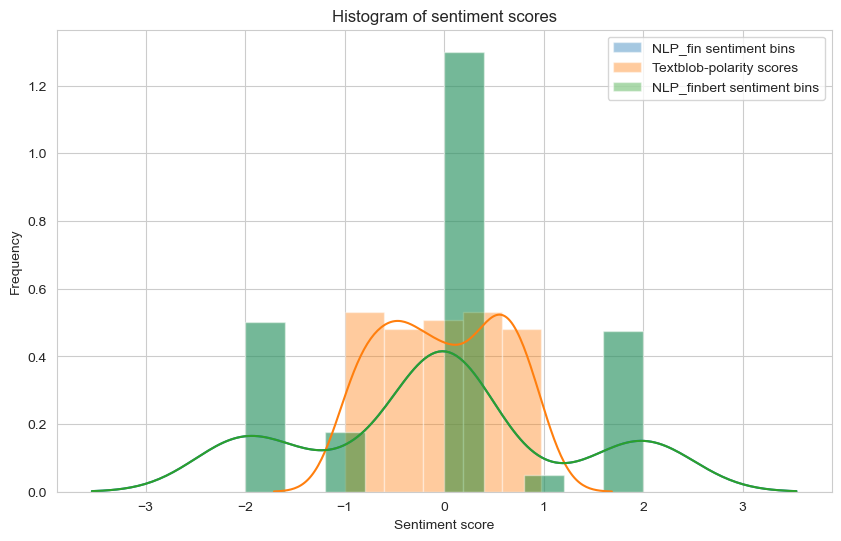

In [28]:
# set the plot size
plt.figure(figsize=(10, 6))

# plot a histogram of the OPT_sentiment-text column
# sns.distplot(media_data['OPT_SC-sentiment'], label = 'OPT sentiment scores')

# plot a histogram of distilRoberta_fin column
sns.distplot(media_data['NLP_fin-bin'], label = 'distilRoberta_fin sentiment bins')

# plot a histogram of the polarity from TextBlob scores column
sns.distplot(media_data['Polarity'], label = 'Textblob-polarity scores', bins = 5)

# plot a histogram of the NLP_finbert-sentiment-text column
sns.distplot(media_data['finbert-bin'], label = 'FinBert sentiment bins')

# set the title and labels
plt.title('Histogram of sentiment scores')
plt.xlabel('Sentiment score')
plt.ylabel('Frequency')

# show the legend
plt.legend()